<a href="https://colab.research.google.com/github/johnymephisto/Machine-Learning-and-Deep-Learning-Experiments/blob/master/Adanet_Implementation_for_text_classification_with_tf_hub.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Adanet implementation with TF-Hub for multiclass text classification

[Adanet](https://arxiv.org/pdf/1607.01097.pdf) is a framework that uses ensemble learning.
 This model used ensemble of 2 DNN architectures that use two different text embeddings formed from tf-hub modules.
 
 The dataset used for this sample implementation is the stackoverflow dataset.

In [0]:
#install adanet and tensorflow version
!pip install adanet
!pip install tensorflow==1.10

Download the [dataset](https://storage.googleapis.com/tensorflow-workshop-examples/stack-overflow-data.csv) and import the required modules.

In [2]:
import logging
import pandas as pd
import numpy as np
from numpy import random
import nltk
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import re
from bs4 import BeautifulSoup

import urllib

nltk.download('stopwords')

urllib.request.urlretrieve("https://storage.googleapis.com/tensorflow-workshop-examples/stack-overflow-data.csv", 'stack-overflow-data.csv')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


('stack-overflow-data.csv', <http.client.HTTPMessage at 0x7f253d59fe80>)

Remove the empty rows not having tags

In [3]:
df = pd.read_csv('stack-overflow-data.csv')
df = df[pd.notnull(df['tags'])]
df.head(10)

,post,tags
0,what is causing this behavior in our c# datet...,c#
1,have dynamic html load as if it was in an ifra...,asp.net
2,how to convert a float value in to min:sec i ...,objective-c
3,.net framework 4 redistributable just wonderi...,.net
4,trying to calculate and print the mean and its...,python
5,how to give alias name for my website i have ...,asp.net
6,window.open() returns null in angularjs it wo...,angularjs
7,identifying server timeout quickly in iphone ...,iphone
8,unknown method key error in rails 2.3.8 unit ...,ruby-on-rails
9,from the include how to show and hide the con...,angularjs


Plot the distribution of classes and their instances. This dataset is well balanced. No need to do any sort of oversampling of undersampling.

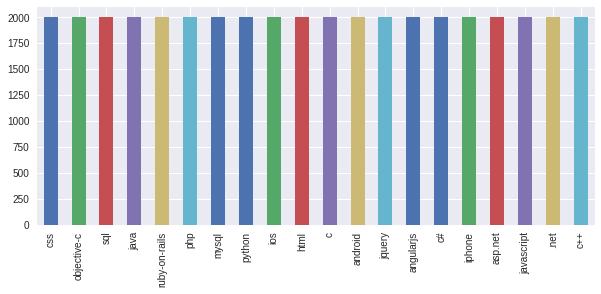

In [5]:
my_tags = ['java','html','asp.net','c#','ruby-on-rails','jquery','mysql','php','ios','javascript','python','c','css','android','iphone','sql','objective-c','c++','angularjs','.net']
plt.figure(figsize=(10,4))
df.tags.value_counts().plot(kind='bar');

In [6]:
def print_plot(index):
    example = df[df.index == index][['post', 'tags']].values[0]
    if len(example) > 0:
        print(example[0])
        print('Tag:', example[1])
        
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = BeautifulSoup(text, "lxml").text # HTML decoding
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwors from text
    return text

df['post'] = df['post'].apply(clean_text)

3424297

Split the train and test set

In [0]:
X = df.post
y = df.tags
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)

## Model Development

Setup encoders with tf-hub

In [0]:
import functools
import urllib

import adanet
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
import tensorflow_hub as hub

#directory for saving exports
model_dir='model'
batch_size=64
total_steps=40000


encoder = LabelEncoder()
encoder.fit_transform(np.array(y_train))
train_encoded = encoder.transform(y_train)
test_encoded = encoder.transform(y_test)
print(encoder.classes_)
num_classes = len(encoder.classes_)


ndim_embeddings = hub.text_embedding_column(
  "ndim",
  module_spec="https://tfhub.dev/google/nnlm-en-dim128/1", trainable=False 
)
encoder_embeddings = hub.text_embedding_column(
  "encoder", 
  module_spec="https://tfhub.dev/google/universal-sentence-encoder/2", trainable=False)


['.net' 'android' 'angularjs' 'asp.net' 'c' 'c#' 'c++' 'css' 'html' 'ios'
 'iphone' 'java' 'javascript' 'jquery' 'mysql' 'objective-c' 'php'
 'python' 'ruby-on-rails' 'sql']
INFO:tensorflow:Using /tmp/tfhub_modules to cache modules.
INFO:tensorflow:Downloading TF-Hub Module 'https://tfhub.dev/google/nnlm-en-dim128/1'.
INFO:tensorflow:Downloaded https://tfhub.dev/google/nnlm-en-dim128/1, Total size: 483.54MB
INFO:tensorflow:Downloaded TF-Hub Module 'https://tfhub.dev/google/nnlm-en-dim128/1'.
INFO:tensorflow:Downloading TF-Hub Module 'https://tfhub.dev/google/universal-sentence-encoder/2'.
INFO:tensorflow:Downloaded https://tfhub.dev/google/universal-sentence-encoder/2, Total size: 993.27MB
INFO:tensorflow:Downloaded TF-Hub Module 'https://tfhub.dev/google/universal-sentence-encoder/2'.
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpjbgbwynp', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpo

Define the input functions for train, eval and also serving input function for prediction mode.

In [0]:
train_features = {
  "ndim": X_train,
  "encoder": X_train
}

train_labels = np.array(train_encoded).astype(np.int32)

eval_features = {
  "ndim": X_test,
  "encoder": X_test
}

eval_labels = np.array(test_encoded).astype(np.int32)

def input_fn_train():
    dataset = tf.data.Dataset.from_tensor_slices((train_features, train_labels))
    dataset = dataset.repeat().shuffle(100).batch(batch_size)
    iterator = dataset.make_one_shot_iterator()
    data, labels = iterator.get_next()
    return data, labels

def input_fn_eval():
    dataset = tf.data.Dataset.from_tensor_slices((eval_features, eval_labels))
    dataset = dataset.batch(batch_size)
    iterator = dataset.make_one_shot_iterator()
    data, labels = iterator.get_next()
    return data, labels


def serving_input_fn():
    feature_placeholders = {
      'encoder' : tf.placeholder(tf.string, [None]),
      'ndim' : tf.placeholder(tf.string, [None])
    }

    return tf.estimator.export.ServingInputReceiver(feature_placeholders, feature_placeholders)

Define the estimators and the adanet ensemble estimator.

Train and evaluate the estimator.

In [0]:
multi_class_head = tf.contrib.estimator.multi_class_head(
  len(encoder.classes_),
  loss_reduction=tf.losses.Reduction.SUM_OVER_BATCH_SIZE
)

estimator_ndim = tf.contrib.estimator.DNNEstimator(
  head=multi_class_head,
  hidden_units=[64,10],
  feature_columns=[ndim_embeddings]
)

estimator_encoder = tf.contrib.estimator.DNNEstimator(
  head=multi_class_head,
  hidden_units=[64,10],
  feature_columns=[encoder_embeddings]
)

# AutoEnsembleEstimator for adanet
estimator = adanet.AutoEnsembleEstimator(
    head=multi_class_head,
    candidate_pool=[
        estimator_encoder,
        estimator_ndim
    ],
    config=tf.estimator.RunConfig(
      save_summary_steps=1000,
      save_checkpoints_steps=1000,
      model_dir=model_dir
    ),
    max_iteration_steps=5000)

train_spec = tf.estimator.TrainSpec(
  input_fn=input_fn_train,
  max_steps=total_steps
)

eval_spec=tf.estimator.EvalSpec(
  input_fn=input_fn_eval,
  steps=None,
  start_delay_secs=10,
  throttle_secs=10
)

tf.estimator.train_and_evaluate(estimator, train_spec, eval_spec)

Export the estimator 

In [0]:
latest_ckpt = tf.train.latest_checkpoint(model_dir)
last_eval = estimator.evaluate(
  input_fn_eval,
  checkpoint_path=latest_ckpt
)

# Export the model to GCS for serving
exporter = tf.estimator.LatestExporter('exporter', serving_input_fn, exports_to_keep=None)
exporter.export(estimator, model_dir, latest_ckpt, last_eval, is_the_final_export=True)